<a href="https://colab.research.google.com/github/liliya-ily/face_vae/blob/main/face_vae.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# В данном проекте используются вариационные автоэнкодеры, для построения лиц знаменитостей

## Импортируются необходимые библиотеки

In [18]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

from glob import glob
# from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras import Model, regularizers
from tensorflow.keras.layers import Input, Dense, Dropout, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow import keras
import matplotlib.pyplot as plt
import cv2 as cv
import matplotlib.pyplot as plt

## Скачивание данных с kaggle.com

In [4]:
! pip install -q kaggle

In [5]:
from google.colab import files

In [6]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"lilyily","key":"b4ffc25ec12416cfc425e1ce7c0b61ea"}'}

In [7]:
! mkdir ~/.kaggle

In [8]:
! cp kaggle.json ~/.kaggle/

In [9]:
 !chmod 600 ~/.kaggle/kaggle.json

In [10]:
!pip install --upgrade --force-reinstall --no-deps kaggle

     |████████████████████████████████| 61kB 3.4MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.12-cp37-none-any.whl size=73053 sha256=b6845c8d98347dc2c1174428cc1f1d04206931c0505634947b10f2ba0dbcd3d6
  Stored in directory: /root/.cache/pip/wheels/a1/6a/26/d30b7499ff85a4a4593377a87ecf55f7d08af42f0de9b60303
Successfully built kaggle
  Found existing installation: kaggle 1.5.12
    Uninstalling kaggle-1.5.12:
      Successfully uninstalled kaggle-1.5.12


In [11]:
!kaggle datasets download -d jessicali9530/celeba-dataset

 99% 1.32G/1.33G [00:06<00:00, 216MB/s]
100% 1.33G/1.33G [00:06<00:00, 207MB/s]


In [ ]:
! unzip /content/celeba-dataset.zip -d kaggle 

В файле содержится более 200000 файлов, поэтому их приходится удалять, чтобы не перегружать colab



In [30]:
!rm -f /content/kaggle/img_align_celeba/img_align_celeba/19*
!rm -f /content/kaggle/img_align_celeba/img_align_celeba/18*
!rm -f /content/kaggle/img_align_celeba/img_align_celeba/17*
!rm -f /content/kaggle/img_align_celeba/img_align_celeba/16*
!rm -f /content/kaggle/img_align_celeba/img_align_celeba/15*
!rm -f /content/kaggle/img_align_celeba/img_align_celeba/14*
!rm -f /content/kaggle/img_align_celeba/img_align_celeba/13*
!rm -f /content/kaggle/img_align_celeba/img_align_celeba/12*
!rm -f /content/kaggle/img_align_celeba/img_align_celeba/11*
!rm -f /content/kaggle/img_align_celeba/img_align_celeba/10*
!rm -f /content/kaggle/img_align_celeba/img_align_celeba/2*
!rm -f /content/kaggle/img_align_celeba/img_align_celeba/01*
!rm -f /content/kaggle/img_align_celeba/img_align_celeba/02*
!rm -f /content/kaggle/img_align_celeba/img_align_celeba/03*
!rm -f /content/kaggle/img_align_celeba/img_align_celeba/04*
!rm -f /content/kaggle/img_align_celeba/img_align_celeba/05*
!rm -f /content/kaggle/img_align_celeba/img_align_celeba/06*
!rm -f /content/kaggle/img_align_celeba/img_align_celeba/07*
!rm -f /content/kaggle/img_align_celeba/img_align_celeba/08*
!rm -f /content/kaggle/img_align_celeba/img_align_celeba/09*
!rm -f /content/kaggle/img_align_celeba/img_align_celeba/001*
!rm -f /content/kaggle/img_align_celeba/img_align_celeba/002*
!rm -f /content/kaggle/img_align_celeba/img_align_celeba/003*
!rm -f /content/kaggle/img_align_celeba/img_align_celeba/004*
!rm -f /content/kaggle/img_align_celeba/img_align_celeba/005*
!rm -f /content/kaggle/img_align_celeba/img_align_celeba/006*
!rm -f /content/kaggle/img_align_celeba/img_align_celeba/007*
!rm -f /content/kaggle/img_align_celeba/img_align_celeba/008*
!rm -f /content/kaggle/img_align_celeba/img_align_celeba/009*
# !ls /content/kaggle/img_align_celeba/img_align_celeba


Проверка загружаемых данных

In [ ]:
os.listdir('/content/kaggle/img_align_celeba/img_align_celeba/')

In [ ]:
# os.listdir('/content/kaggle/cats')

['CAT_04', 'CAT_05', 'CAT_03', 'CAT_01', 'CAT_06', 'CAT_00', 'CAT_02']

## Подготовка изображений

In [19]:
def img_preprocess():
    img_list = []
    for img_path in glob('/content/kaggle/img_align_celeba/img_align_celeba/*.jpg'):
        img = cv.imread(img_path)            # cv - 3-мерный массив, last_channel = 3, трехэлементный цвет RGB.
        img = cv.cvtColor(img, cv.COLOR_BGR2RGB) # - OpenCV считывает изображения в BGR, а не RGB, поэтому нужно преобразование
        img = cv.resize(img, (180, 180))     # Преобразование формы в (224, 224)
        sc_img = img.astype('float') / 255   # Нормализация
        img_list.append(sc_img)
    
    return np.asarray(img_list)

In [20]:
img_arr = img_preprocess()

### Вывод полученных изображений

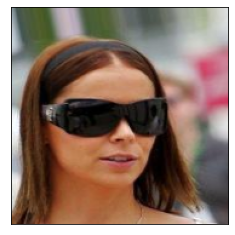

In [21]:
plt.imshow(img_arr[3]);
plt.xticks([]);
plt.yticks([]);

In [22]:
img_arr.shape

(999, 180, 180, 3)

## Построение модели VAE

## Разделение данных на x_train, x_test

In [23]:
from sklearn.model_selection import train_test_split
(x_train, x_test) = train_test_split(img_arr, test_size = 0.10, random_state = 0)


### Построение нейронной сети

In [33]:
from tensorflow.keras.layers import *
from tensorflow.keras import Model
from tensorflow.keras import backend as K
from tensorflow.keras.losses import mse


def sampling(args):
    """Reparameterization trick by sampling fr an isotropic unit Gaussian.

    # Arguments
        args (tensor): mean and log of variance of Q(z|X)

    # Returns
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean=0 and std=1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

# network parameters
input_shape = (x_train.shape[1], x_train.shape[2], 3)
filters = 16
latent_dim = 16


inputs = Input(shape=input_shape, name='encoder_input')

x = inputs

for i in range(2):
    x = Conv2D(filters=filters,
               kernel_size=3,
               activation='relu',
               strides=2,
               padding='same')(x)
    filters *= 2

shape = K.int_shape(x)

x = Flatten()(x)

x = Dense(32, activation='relu')(x)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)

z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()

latent_inputs = Input(shape=(latent_dim,), name='z_sampling')

x = Dense(shape[1] * shape[2] * shape[3], activation='relu')(latent_inputs)
x = Reshape((shape[1], shape[2], shape[3]))(x)

for i in range(2):
    filters //= 2
    x = Conv2DTranspose(filters=filters,
                        kernel_size=3,
                        activation='relu',
                        strides=2,
                        padding='same')(x)

outputs = Conv2DTranspose(filters=3,
                          kernel_size=3,
                          activation='sigmoid',
                          padding='same',
                          name='decoder_output')(x)

decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

outputs = decoder(encoder(inputs)[2])

vae = Model(inputs, outputs, name='vae')

reconstruction_loss = mse(K.flatten(inputs), K.flatten(outputs))
# reconstruction_loss *= x_train.shape[1]*x_train.shape[2]

kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5

vae_loss = K.mean(reconstruction_loss + 1e-3*kl_loss)
vae.add_loss(vae_loss)
vae.add_metric(reconstruction_loss, 'rec_loss')
vae.add_metric(kl_loss, 'kl_loss')

vae.compile(optimizer=keras.optimizers.Adam(lr=0.01))

vae.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 180, 180, 3) 0                                            
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 90, 90, 16)   448         encoder_input[0][0]              
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 45, 45, 32)   4640        conv2d_4[0][0]                   
__________________________________________________________________________________________________
flatten_2 (Flatten)             (None, 64800)        0           conv2d_5[0][0]                   
____________________________________________________________________________________________

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [34]:
vae.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001))

In [ ]:
vae.fit(
    x_train,
    x_train,
    epochs=20,
    batch_size=128,
    validation_data=(x_test, x_test),
#     callbacks=[EarlyStopping(monitor='val_loss', min_delta=0, patience=30, restore_best_weights=True)]
)

Epoch 1/20
8/8 [==============================] - 35s 4s/step - loss: 0.0925 - rec_loss: 0.0903 - kl_loss: 2.4562 - val_loss: 0.0914 - val_rec_loss: 0.0914 - val_kl_loss: 1.1829e-04
Epoch 2/20
8/8 [==============================] - 33s 4s/step - loss: 0.0918 - rec_loss: 0.0918 - kl_loss: 1.6471e-04 - val_loss: 0.0901 - val_rec_loss: 0.0901 - val_kl_loss: 2.2778e-04
Epoch 3/20
8/8 [==============================] - 33s 4s/step - loss: 0.0881 - rec_loss: 0.0881 - kl_loss: 2.5671e-04 - val_loss: 0.0887 - val_rec_loss: 0.0887 - val_kl_loss: 3.0091e-04
Epoch 4/20
8/8 [==============================] - 33s 4s/step - loss: 0.0902 - rec_loss: 0.0902 - kl_loss: 3.2842e-04 - val_loss: 0.0879 - val_rec_loss: 0.0879 - val_kl_loss: 3.8743e-04
Epoch 5/20
8/8 [==============================] - 33s 4s/step - loss: 0.0865 - rec_loss: 0.0865 - kl_loss: 4.2630e-04 - val_loss: 0.0875 - val_rec_loss: 0.0875 - val_kl_loss: 4.3142e-04
Epoch 6/20
8/8 [==============================] - 33s 4s/step - loss: 0.08

In [1]:
# for i in range(10):
#   plt.figure(figsize=(2,2))
#   plt.title(i)
#   plt.imshow(x_test[i])
#   plt.show()

In [27]:
test_rec = vae.predict(x_test)

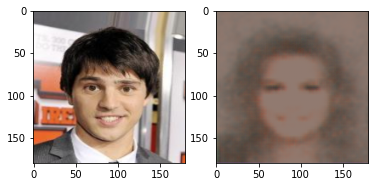

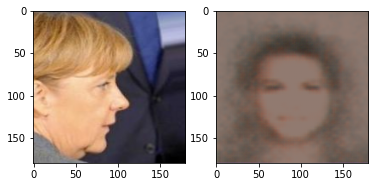

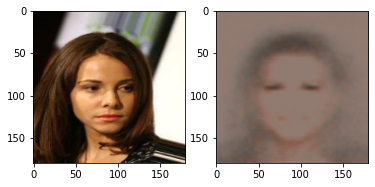

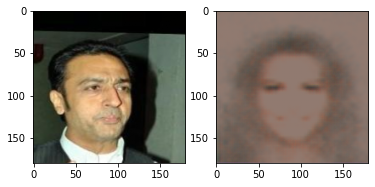

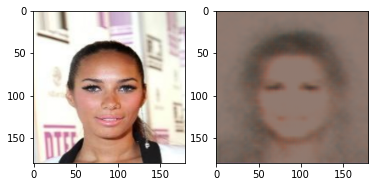

In [31]:

for i in range(5):
    fig, ax = plt.subplots(1, 2)
    
    ax[0].imshow(x_test[i+12], vmin=0, vmax=1)
    # plt.show()
    # plt.figure(figsize=(1,1))
    ax[1].imshow(test_rec[i+12], vmin=0, vmax=1)
    # plt.show()

NameError: ignored

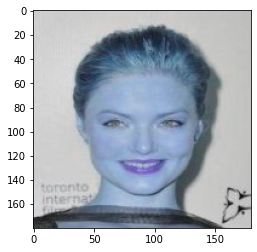

In [ ]:
i1, i2 = 85, 88

plt.imshow(x_test[i1])
plt.title(y_test[i1])
plt.show()
plt.imshow(x_test[i2])
plt.title(y_test[i2]);